In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import time
import psutil


# Mount Google Drive
drive.mount('/content/drive')

# Define paths to data folders
macro_folder = '/content/drive/MyDrive/processed_data'
financial_folder = '/content/drive/MyDrive/financial_info'
countries = ['brazil', 'india', 'south_africa']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Display Random Forest characteristics
rf_characteristics = {
    'Algorithm Type': 'Bagging (Bootstrap Aggregating)',
    'Model Building': 'Independent trees built on bootstrap samples',
    'Training Speed': 'Faster due to parallel processing',
    'Prediction Speed': 'Fast',
    'Handling Imbalanced Data': 'Moderate',
    'Handling Missing Values': 'Built-in handling via surrogate splits',
    'Feature Selection': 'Built-in, provides feature importance',
    'Hyperparameter Sensitivity': 'Less sensitive, easier to tune',
    'Overfitting Risk': 'Lower due to averaging of multiple trees',
    'Regularization': 'Implicit through randomization',
    'Memory Usage': 'Higher, storing many trees'
}

pd.DataFrame([rf_characteristics]).T.rename(columns={0: 'Characteristic'})


Characteristic
Algorithm Type                           Bagging (Bootstrap Aggregating)
Model Building              Independent trees built on bootstrap samples
Training Speed                         Faster due to parallel processing
Prediction Speed                                                    Fast
Handling Imbalanced Data                                        Moderate
Handling Missing Values           Built-in handling via surrogate splits
Feature Selection                  Built-in, provides feature importance
Hyperparameter Sensitivity                Less sensitive, easier to tune
Overfitting Risk                Lower due to averaging of multiple trees
Regularization                            Implicit through randomization
Memory Usage                                  Higher, storing many trees

In [ ]:
# Display XGBoost characteristics
xgb_characteristics = {
    'Algorithm Type': 'Boosting (Sequential ensemble)',
    'Model Building': 'Sequential trees that correct previous errors',
    'Training Speed': 'Slower due to sequential nature',
    'Prediction Speed': 'Fast',
    'Handling Imbalanced Data': 'Better',
    'Handling Missing Values': 'Built-in handling via sparsity-aware split finding',
    'Feature Selection': 'Built-in, provides feature importance',
    'Hyperparameter Sensitivity': 'More sensitive, requires careful tuning',
    'Overfitting Risk': 'Higher, requires regularization',
    'Regularization': 'Explicit (L1, L2) requiring parameter tuning',
    'Memory Usage': 'Lower, more efficient data structures'
}

pd.DataFrame([xgb_characteristics]).T.rename(columns={0: 'Characteristic'})


Characteristic
Algorithm Type                                 Boosting (Sequential ensemble)
Model Building                  Sequential trees that correct previous errors
Training Speed                                Slower due to sequential nature
Prediction Speed                                                         Fast
Handling Imbalanced Data                                               Better
Handling Missing Values     Built-in handling via sparsity-aware split fin...
Feature Selection                       Built-in, provides feature importance
Hyperparameter Sensitivity            More sensitive, requires careful tuning
Overfitting Risk                              Higher, requires regularization
Regularization                   Explicit (L1, L2) requiring parameter tuning
Memory Usage                            Lower, more efficient data structures

In [121]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
import xgboost as xgb
from xgboost import XGBRegressor
import shap
import time
import psutil
import warnings
warnings.filterwarnings('ignore')

# Load data
macro_folder = '/content/drive/MyDrive/processed_data'
financial_folder = '/content/drive/MyDrive/financial_info'

def load_country_data(country_name, macro_folder, financial_folder):
    """Load stock and macro data with proper handling of problematic rows"""
    # Define file paths based on country name (lowercase for consistency)
    country_lower = country_name.lower()
    stock_file = f'{financial_folder}/{country_lower}_stock.csv'
    macro_file = f'{macro_folder}/{country_lower}_macro.csv'

    # Load stock data - skip ticker symbol row (row 1)
    stock_df = pd.read_csv(stock_file, parse_dates=['Date'], skiprows=[1])

    # Load macro data
    macro_df = pd.read_csv(macro_file, parse_dates=['date'])

    print(f"Loaded {country_name} data: {stock_df.shape[0]} stock rows, {macro_df.shape[0]} macro rows")

    return stock_df, macro_df




In [122]:
def preprocess_country_data(stock_df, macro_df, country_name):
    """Process stock and macro data with proper handling of duplicates and missing values"""
    # Create copies to avoid modifying original data
    stock_df = stock_df.copy()
    macro_df = macro_df.copy()

    # Standardize all column names to lowercase
    stock_df.columns = [col.lower() for col in stock_df.columns]
    macro_df.columns = [col.lower() for col in macro_df.columns]

    # Ensure date column is properly named
    if 'date' not in stock_df.columns and 'Date' in stock_df.columns:
        stock_df = stock_df.rename(columns={'Date': 'date'})

    # Convert close price to numeric, handling any non-numeric values
    if 'close' in stock_df.columns:
        stock_df['close'] = pd.to_numeric(stock_df['close'], errors='coerce')

    # Calculate returns and volatility
    stock_df['return_1m'] = stock_df['close'].pct_change(1)
    stock_df['return_3m'] = stock_df['close'].pct_change(3)
    stock_df['volatility'] = stock_df['return_1m'].rolling(20).std()

    # Remove duplicated columns (keep only columns without suffix)
    # This is critical for handling the triplicated columns in macro data
    macro_cols_to_keep = [col for col in macro_df.columns
                         if not col.endswith('_x') and not col.endswith('_y') and col != 'date']

    # Print available macro columns for debugging
    print(f"Available macro columns for {country_name}: {macro_cols_to_keep}")

    # Keep only unique columns
    macro_df = macro_df[['date'] + macro_cols_to_keep]

    # Convert all macro columns to numeric
    for col in macro_cols_to_keep:
        macro_df[col] = pd.to_numeric(macro_df[col], errors='coerce')

    # Sort dataframes by date before merging
    stock_df = stock_df.sort_values('date')
    macro_df = macro_df.sort_values('date')

    # Forward fill missing values in macro data
    # This is crucial for time series data with occasional missing values
    macro_df = macro_df.set_index('date')
    macro_df = macro_df.ffill()  # Forward fill
    macro_df = macro_df.reset_index()

    # Merge stock and macro data (using merge_asof for time series data)
    df = pd.merge_asof(stock_df, macro_df, on='date')

    # Calculate percentage changes for macro columns
    for col in macro_cols_to_keep:
        if col in df.columns:
            df[f'{col}_change'] = df[col].pct_change(1).fillna(0)  # Fill NaN from pct_change with 0

    df['country'] = country_name

    # Print column names and number of non-null values
    print(f"Non-null counts in {country_name} dataframe:")
    print(df.count().sort_values())

    return df


# Process and combine data
brazil_df = preprocess_country_data(brazil_stock, brazil_macro, 'Brazil')
india_df = preprocess_country_data(india_stock, india_macro, 'India')
sa_df = preprocess_country_data(sa_stock, sa_macro, 'South Africa')
combined_df = pd.concat([brazil_df, india_df, sa_df])


Available macro columns for Brazil: ['imports', 'exports', 'gdp', 'interest_rate', 'cpi', 'exchange_rate']
Non-null counts in Brazil dataframe:
gdp                     127
volatility              128
cpi                     133
interest_rate           136
imports                 139
exports                 139
return_3m               145
exchange_rate           145
return_1m               147
volume                  148
open                    148
low                     148
close                   148
date                    148
high                    148
imports_change          148
exports_change          148
gdp_change              148
interest_rate_change    148
cpi_change              148
exchange_rate_change    148
country                 148
dtype: int64
Available macro columns for India: ['imports', 'exports', 'interest_rate', 'gdp', 'exchange_rate', 'cpi']
Non-null counts in India dataframe:
gdp                     124
exchange_rate           124
cpi                     124
i

In [123]:
def define_market_regime(df):
    """Define market regimes with proper handling of missing values"""
    # Create a copy to avoid modifying the original
    df_copy = df.copy()

    # Only calculate regimes based on rows with valid return and volatility
    # This avoids dropping all rows with any NaN values
    mask = df_copy['return_1m'].notna() & df_copy['volatility'].notna()
    valid_data = df_copy[mask]

    # Calculate quantiles only on valid data
    return_high = valid_data['return_1m'].quantile(0.7)
    return_low = valid_data['return_1m'].quantile(0.3)
    vol_high = valid_data['volatility'].quantile(0.7)

    print(f"Regime thresholds - Return high: {return_high:.4f}, Return low: {return_low:.4f}, Vol high: {vol_high:.4f}")

    # Define conditions for regimes (0: Bear, 1: Sideways, 2: Bull)
    conditions = [
        (df_copy['return_1m'] < return_low) & (df_copy['volatility'] > vol_high),
        (df_copy['return_1m'] >= return_low) & (df_copy['return_1m'] <= return_high),
        (df_copy['return_1m'] > return_high)
    ]
    choices = [0, 1, 2]

    # Apply conditions to create regime column
    df_copy['regime'] = np.select(conditions, choices, default=1)

    # Print regime distribution
    regime_counts = df_copy['regime'].value_counts()
    print(f"Regime distribution: {regime_counts.to_dict()}")

    return df_copy



# First, define regimes (using only necessary columns)
combined_df = define_market_regime(combined_df)

# Verify regime column exists
print(f"Combined DataFrame columns: {combined_df.columns.tolist()}")
print(f"Number of rows with regime values: {combined_df['regime'].count()}")

# Fill NaN values in percentage change columns (these often have NaN in first row)
for f in features:
    if f.endswith('_change'):
        combined_df[f] = combined_df[f].fillna(0)

# Now drop remaining NaNs in the features
combined_df_clean = combined_df.dropna(subset=features)

# Final check before creating X and y
if 'regime' in combined_df_clean.columns:
    X = combined_df_clean[features]
    y = combined_df_clean['regime']
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")
else:
    raise KeyError("Regime column not found in cleaned DataFrame")


Regime thresholds - Return high: 0.0382, Return low: -0.0208, Vol high: 0.0726
Regime distribution: {1: 284, 2: 128, 0: 32}
Combined DataFrame columns: ['date', 'close', 'high', 'low', 'open', 'volume', 'return_1m', 'return_3m', 'volatility', 'imports', 'exports', 'gdp', 'interest_rate', 'cpi', 'exchange_rate', 'imports_change', 'exports_change', 'gdp_change', 'interest_rate_change', 'cpi_change', 'exchange_rate_change', 'country', 'bond_yields', 'unemployment', 'bond_yields_change', 'unemployment_change', 'regime']
Number of rows with regime values: 444
Shape of X: (375, 12)
Shape of y: (375,)


In [125]:
# Process and combine data
countries = ['brazil', 'india', 'south_africa']
country_dfs = {}

for country in countries:
    stock_df, macro_df = load_country_data(country, macro_folder, financial_folder)
    country_dfs[country] = preprocess_country_data(stock_df, macro_df, country)

combined_df = pd.concat(list(country_dfs.values()))

# Define market regimes
combined_df = define_market_regime(combined_df)

# Select features with lowercase names to match preprocessed data
features = ['return_1m', 'return_3m', 'volatility', 'gdp', 'cpi',
            'exchange_rate', 'imports', 'exports', 'gdp_change',
            'cpi_change', 'imports_change', 'exports_change']

# Print available columns to verify
print("Available columns:", sorted(combined_df.columns.tolist()))

# Keep only features that exist in the dataset
available_features = [f for f in features if f in combined_df.columns]
print(f"Selected features: {available_features}")

# Fill missing values in features to prevent excessive data loss
for feature in available_features:
    if feature.endswith('_change'):
        # Fill NaN in percentage change features with 0
        combined_df[feature] = combined_df[feature].fillna(0)
    else:
        # Forward fill other features
        combined_df[feature] = combined_df[feature].ffill()

# Prepare clean dataset for modeling
X = combined_df[available_features]
y = combined_df['regime']

print(f"Final dataset shape - X: {X.shape}, y: {y.shape}")

# Use TimeSeriesSplit instead of regular train_test_split to prevent data leakage
from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Get the last split for final evaluation
train_indices = []
test_indices = []

for train_index, test_index in tscv.split(X):
    train_indices = train_index
    test_indices = test_index

X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Loaded brazil data: 148 stock rows, 52 macro rows
Available macro columns for brazil: ['imports', 'exports', 'gdp', 'interest_rate', 'cpi', 'exchange_rate']
Non-null counts in brazil dataframe:
gdp                     127
volatility              128
cpi                     133
interest_rate           136
imports                 139
exports                 139
return_3m               145
exchange_rate           145
return_1m               147
volume                  148
open                    148
low                     148
close                   148
date                    148
high                    148
imports_change          148
exports_change          148
gdp_change              148
interest_rate_change    148
cpi_change              148
exchange_rate_change    148
country                 148
dtype: int64
Loaded india data: 148 stock rows, 52 macro rows
Available macro columns for india: ['imports', 'exports', 'interest_rate', 'gdp', 'exchange_rate', 'cpi']
Non-null counts in ind

In [126]:
# Use KFold instead of StratifiedKFold for regression tasks
from sklearn.model_selection import KFold

# Initialize models
models = {
    'RF-100': RandomForestRegressor(n_estimators=100, random_state=42),
    'RF-200': RandomForestRegressor(n_estimators=200, random_state=42),
    'RF-500': RandomForestRegressor(n_estimators=500, random_state=42),
    'XGB-100': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGB-200': XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

# Cross-validation with KFold
k_values = [3, 5, 7]
cv_results = {}

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_results[k] = {}

    for name, model in models.items():
        r2_scores = cross_val_score(model, X_train_scaled, y_train,
                                   cv=kf, scoring='r2')
        cv_results[k][name] = {
            'r2_mean': r2_scores.mean(),
            'r2_std': r2_scores.std()
        }

# Train models and collect metrics
train_results = {}
test_results = {}
training_times = {}
memory_usage = {}
feature_importances = {}

for name, model in models.items():
    print(f"Training {name}...")

    # Measure training time and memory
    mem_before = psutil.virtual_memory().percent
    start_time = time.time()

    model.fit(X_train_scaled, y_train)

    training_times[name] = time.time() - start_time
    mem_after = psutil.virtual_memory().percent
    memory_usage[name] = mem_after - mem_before

    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importances[name] = dict(zip(available_features, importances))

    # Predictions - round for classification metrics
    y_train_pred = np.round(model.predict(X_train_scaled)).astype(int)
    y_test_pred = np.round(model.predict(X_test_scaled)).astype(int)

    # Training metrics
    train_results[name] = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred, average='weighted'),
        'recall': recall_score(y_train, y_train_pred, average='weighted'),
        'f1': f1_score(y_train, y_train_pred, average='weighted')
    }

    # Test metrics
    test_results[name] = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, average='weighted'),
        'recall': recall_score(y_test, y_test_pred, average='weighted'),
        'f1': f1_score(y_test, y_test_pred, average='weighted')
    }


Training RF-100...
Training RF-200...
Training RF-500...
Training XGB-100...
Training XGB-200...


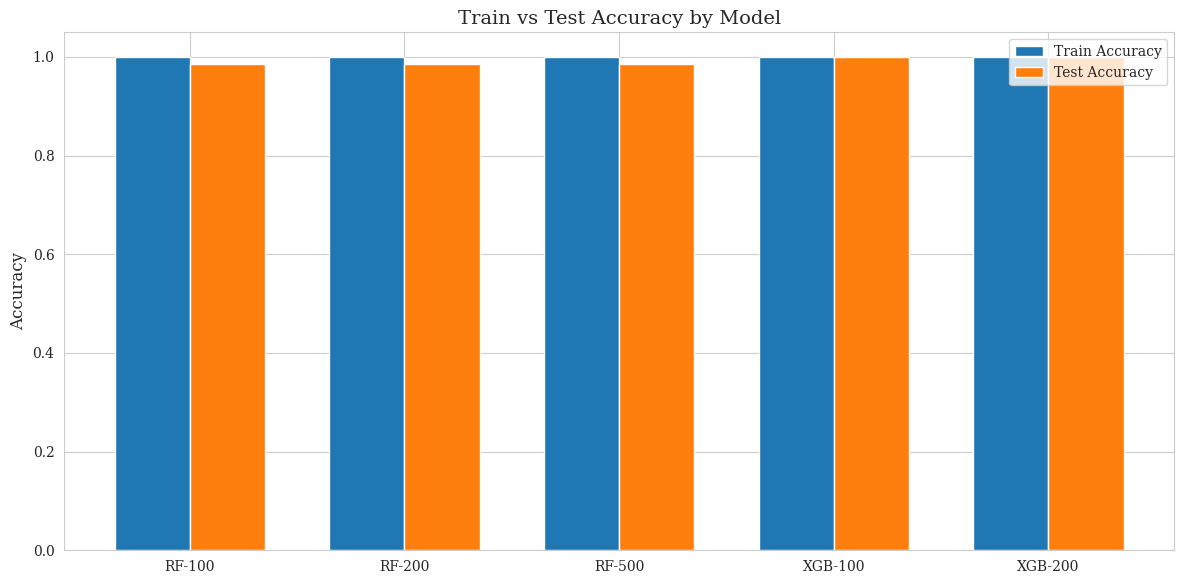

In [127]:
# Plot feature importance
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': models['XGB-200'].feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Features for Market Regime Classification')
plt.tight_layout()
plt.show()

# Plot model performance comparison
plt.figure(figsize=(12, 6))
model_names = list(models.keys())
train_acc = [train_results[m]['accuracy'] for m in model_names]
test_acc = [test_results[m]['accuracy'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, train_acc, width, label='Train Accuracy')
plt.bar(x + width/2, test_acc, width, label='Test Accuracy')
plt.xticks(x, model_names)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy by Model')
plt.legend()
plt.tight_layout()
plt.show()


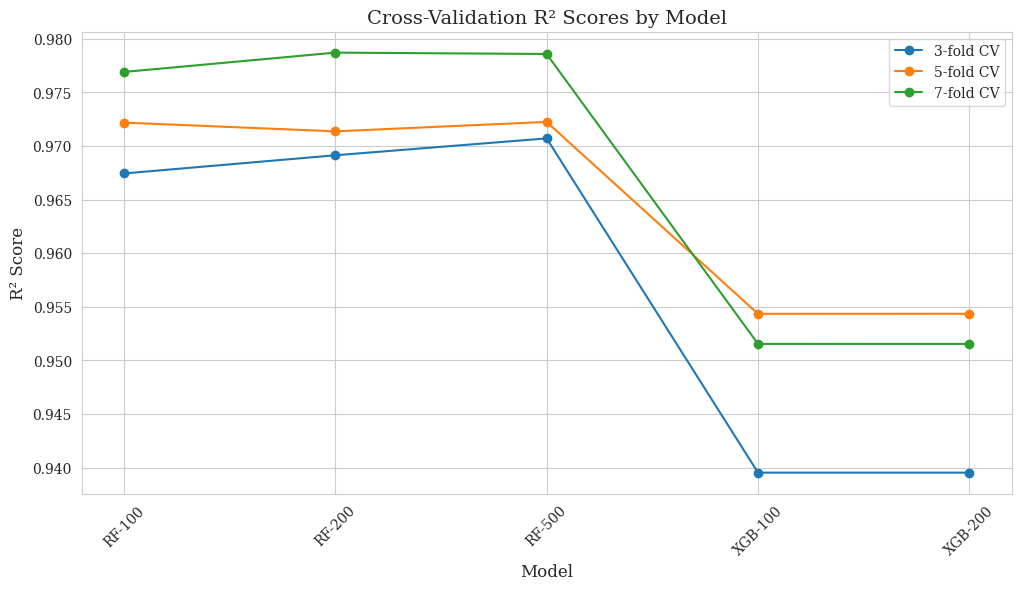

In [128]:
# Plot cross-validation results
plt.figure(figsize=(12, 6))
for k in k_values:
    r2_means = [cv_results[k][model]['r2_mean'] for model in models.keys()]
    plt.plot(models.keys(), r2_means, marker='o', label=f'{k}-fold CV')
plt.title('Cross-Validation R² Scores by Model')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.legend()
plt.show()


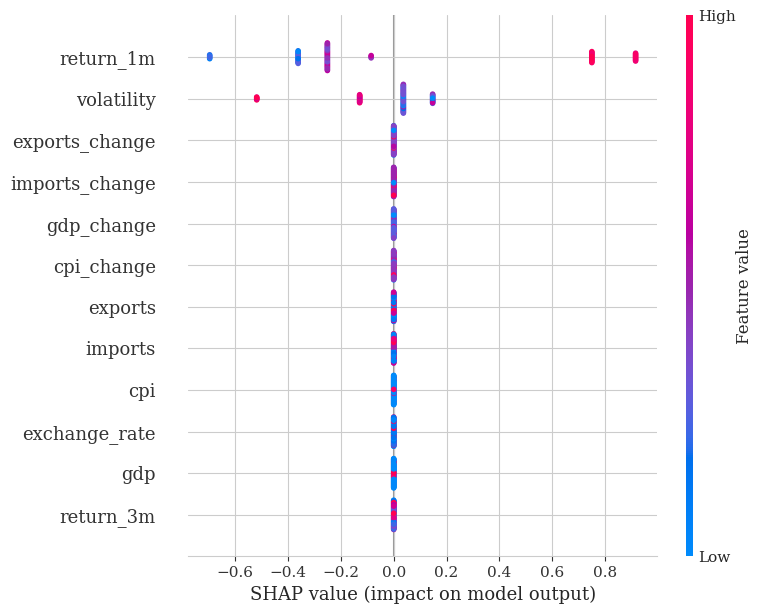

<Figure size 640x480 with 0 Axes>

In [120]:
# Generate SHAP values for the best model
explainer = shap.TreeExplainer(models['XGB-200'])
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=features)
plt.tight_layout()
plt.show()
